In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

import polars as pl
import numpy as np

from adex.models import Condition, ConditionDataLoader, ConditionSequencingTissueDataLoader, \
    ConditionSequencingDataLoader, SequencingTechnique, TissueEnum, METADATA_COLUMNS, FileDataLoader, DataLoader
from adex.helpers import get_pre_processed_dataset
from adex.models import DATASET_INFO_COLUMNS
from sklearn import model_selection

data_path = "../data/adex-database/samples"
metadata_path = "../data/adex-database/metadata.csv"
datasets_info_path = "../data/adex-database/datasets_info.csv"
results_path = "../results"

# Prepare Data

In [51]:
top10_de_genes_ra_GSE89408 = (
    pl
    .read_csv(f"../data/ml/GSE89408_top_de_train_genes.csv", has_header=True)
    .to_series()
    .to_list()
)
len(top10_de_genes_ra_GSE89408)

10

In [52]:
de_GSE89408 = (
    get_pre_processed_dataset(
        data_loader=FileDataLoader(
            condition=Condition.RA,
            file_name="GSE89408.tsv.parquet",
            genes=top10_de_genes_ra_GSE89408
        ),
        data_path=data_path,
        metadata_path=metadata_path,
        datasets_info_path=datasets_info_path,
        return_metadata=True
    ).fill_null(value=0)
    .drop(filter(lambda item: item != 'Condition',METADATA_COLUMNS)) # We need only the condition from Metadata  
    .drop(DATASET_INFO_COLUMNS)
    .with_columns(
        pl.col("Condition")
            .map_elements(lambda x: 0 if x == "Healthy" else 1, return_dtype=pl.Int8)
            .alias("class_label")
    )
    .drop("Condition")
).sort("Sample")  # Remove randomness at this point 
de_GSE89408

Sample,HSPE1-MOB4,AC211429.1,AC017083.2,U62317.1,HOXC-AS1,AC020909.4,AC025259.1,AL139099.1,AC068631.2,AC025423.4,class_label
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8
"""GSM2370970""",0.0,6.472111,0.0,0.0,7.776255,0.0,0.0,0.0,5.322358,0.0,0
"""GSM2370971""",6.562024,3.094096,7.938222,0.0,5.827561,5.274107,6.073492,7.078922,1.326442,7.707919,0
"""GSM2370972""",0.0,3.056805,7.53651,0.858757,5.136107,3.808962,0.0,0.0,2.341239,6.148911,0
"""GSM2370973""",0.0,5.131011,0.0,1.069102,5.965672,0.0,0.0,3.11884,0.0,5.776321,0
"""GSM2370974""",0.0,4.70726,5.758763,0.0,6.059763,3.860753,0.0,0.0,1.963042,4.476259,0
…,…,…,…,…,…,…,…,…,…,…,…
"""GSM2371183""",6.852084,2.606461,7.564782,2.794609,4.167273,4.979133,5.721076,8.181333,6.175148,7.378751,1
"""GSM2371184""",8.125291,2.288607,8.341194,3.255327,1.352949,7.544912,4.777353,10.372098,7.60949,7.99071,1
"""GSM2371185""",6.937231,3.772043,7.450259,3.103816,3.772043,6.416332,5.047704,9.312345,5.154133,8.041741,1


In [53]:
de_GSE89408.select(pl.col("class_label").value_counts()) # Imbalanced data between the two classes

class_label
struct[2]
"{1,152}"
"{0,28}"


In [54]:
x_df = (
        de_GSE89408.select([
            pl.all().exclude("Sample", "class_label"),
        ]).to_pandas()
 )
x_df

,HSPE1-MOB4,AC211429.1,AC017083.2,U62317.1,HOXC-AS1,AC020909.4,AC025259.1,AL139099.1,AC068631.2,AC025423.4
0,0.000000,6.472111,0.000000,0.000000,7.776255,0.000000,0.000000,0.000000,5.322358,0.000000
1,6.562024,3.094096,7.938222,0.000000,5.827561,5.274107,6.073492,7.078922,1.326442,7.707919
2,0.000000,3.056805,7.536510,0.858757,5.136107,3.808962,0.000000,0.000000,2.341239,6.148911
3,0.000000,5.131011,0.000000,1.069102,5.965672,0.000000,0.000000,3.118840,0.000000,5.776321
4,0.000000,4.707260,5.758763,0.000000,6.059763,3.860753,0.000000,0.000000,1.963042,4.476259
...,...,...,...,...,...,...,...,...,...,...
175,6.852084,2.606461,7.564782,2.794609,4.167273,4.979133,5.721076,8.181333,6.175148,7.378751
176,8.125291,2.288607,8.341194,3.255327,1.352949,7.544912,4.777353,10.372098,7.609490,7.990710
177,6.937231,3.772043,7.450259,3.103816,3.772043,6.416332,5.047704,9.312345,5.154133,8.041741
178,6.764702,0.000000,7.930536,2.795792,3.197420,6.813169,5.986713,10.422702,6.608690,7.969548


In [55]:
y_df = de_GSE89408.select(pl.col("class_label").alias("y")).to_pandas()
y_df

,y
0,0
1,0
2,0
3,0
4,0
...,...
175,1
176,1
177,1
178,1


In [56]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    x_df, y_df, 
    train_size=0.7, 
    random_state=42,  # Ensure a reproducible split 
    shuffle=True, 
    stratify=y_df  # solve the class imbalance issue 
)

In [57]:
x_train

,HSPE1-MOB4,AC211429.1,AC017083.2,U62317.1,HOXC-AS1,AC020909.4,AC025259.1,AL139099.1,AC068631.2,AC025423.4
13,0.000000,5.213109,0.000000,1.864341,6.532242,0.000000,0.000000,0.000000,3.828335,4.348193
73,6.102829,2.749214,7.122238,5.518350,2.267737,6.487267,6.062215,10.635017,7.227001,6.921170
4,0.000000,4.707260,5.758763,0.000000,6.059763,3.860753,0.000000,0.000000,1.963042,4.476259
5,0.000000,3.031357,5.965939,3.491997,4.619271,3.617796,0.000000,7.339339,0.000000,7.195406
57,0.000000,0.000000,5.156864,3.369568,3.544659,5.534341,3.841646,9.256971,0.000000,6.887080
...,...,...,...,...,...,...,...,...,...,...
53,6.492915,2.677611,7.649072,4.026287,0.925741,6.189286,3.321436,6.324991,6.967549,7.152249
64,5.741325,1.857876,7.112296,3.523430,3.820045,5.764730,4.857842,9.004779,5.483675,7.582939
176,8.125291,2.288607,8.341194,3.255327,1.352949,7.544912,4.777353,10.372098,7.609490,7.990710
89,5.833912,3.306743,7.224499,6.023392,0.918027,6.062321,5.788198,9.491333,6.887744,8.236785


In [58]:
y_train

,y
13,0
73,1
4,0
5,0
57,1
...,...
53,1
64,1
176,1
89,1


In [59]:
y_train.value_counts()

y
1    106
0     19
Name: count, dtype: int64

In [60]:
x_test

,HSPE1-MOB4,AC211429.1,AC017083.2,U62317.1,HOXC-AS1,AC020909.4,AC025259.1,AL139099.1,AC068631.2,AC025423.4
18,4.951320,1.805233,7.372085,1.413181,4.331076,5.412135,4.206642,8.564358,5.692894,6.437239
98,0.000000,4.286473,8.311990,5.039403,0.000000,2.618922,5.287529,7.929231,4.946210,6.781749
166,6.744603,2.376680,7.457176,4.546265,3.763433,5.757994,4.151664,8.646634,6.334043,8.160634
140,5.722857,0.000000,0.000000,3.368290,2.038738,6.590038,5.778389,9.799556,4.693256,6.408358
29,6.737572,2.206040,7.280784,3.565866,2.206040,5.471475,5.316553,6.973673,5.856029,7.305715
90,0.000000,1.850073,7.198596,2.823497,2.417373,5.528463,4.661924,8.490438,5.682767,6.763955
162,7.737913,1.722972,8.126394,3.730405,3.238416,7.111682,5.380375,9.872784,6.923948,7.445874
105,2.322852,3.001010,5.615841,4.859096,0.000000,5.524691,0.000000,8.922993,3.460481,5.171047
74,6.407781,0.000000,0.000000,3.025182,1.477789,4.649640,5.838809,0.000000,6.345800,0.000000
45,5.766810,0.000000,7.258533,4.430082,3.205202,4.124789,6.578365,9.390506,5.871831,6.697451


In [61]:
y_test

,y
18,0
98,1
166,1
140,1
29,1
90,1
162,1
105,1
74,1
45,1


In [62]:
y_test.value_counts()

y
1    46
0     9
Name: count, dtype: int64

# Logistic Regression 

In [63]:
logistic_model = LogisticRegression(solver='liblinear', random_state=0).fit(x_train, np.ravel(y_train))
logistic_model.intercept_

array([0.04344528])

In [64]:
logistic_model.coef_

array([[ 0.47224376, -0.43851996, -0.28631353,  0.37334052, -1.17207877,
         0.35665901, -0.38956601,  0.11867795,  0.91810734,  0.52761207]])

In [65]:
logistic_model.predict_proba(x_test)

array([[7.67922998e-03, 9.92320770e-01],
       [3.68479063e-03, 9.96315209e-01],
       [1.33545696e-04, 9.99866454e-01],
       [2.57680197e-05, 9.99974232e-01],
       [1.42241334e-04, 9.99857759e-01],
       [4.76689473e-03, 9.95233105e-01],
       [4.06699339e-05, 9.99959330e-01],
       [1.27738949e-04, 9.99872261e-01],
       [4.63297809e-04, 9.99536702e-01],
       [5.34706785e-04, 9.99465293e-01],
       [2.54923610e-06, 9.99997451e-01],
       [5.77534434e-04, 9.99422466e-01],
       [1.76094485e-05, 9.99982391e-01],
       [1.59562933e-06, 9.99998404e-01],
       [1.03510465e-01, 8.96489535e-01],
       [5.52359952e-06, 9.99994476e-01],
       [3.21059478e-04, 9.99678941e-01],
       [9.97908889e-01, 2.09111066e-03],
       [7.64511013e-07, 9.99999235e-01],
       [6.14179936e-05, 9.99938582e-01],
       [2.66115593e-05, 9.99973388e-01],
       [9.38572440e-06, 9.99990614e-01],
       [1.43762883e-02, 9.85623712e-01],
       [7.59313067e-07, 9.99999241e-01],
       [1.696219

In [66]:
logistic_prediction = logistic_model.predict(x_test)
logistic_prediction

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int8)

In [67]:
cm = confusion_matrix(y_test, logistic_prediction)
# Rows: Predictions
# Columns: Facts
# TN FP 
# FN TP 

# TN (Healthy predicted Healthy): 7
# FP (Healthy predicted Diseased): 2
# FN (Diseased predicted Healthy): 0
# TP (Diseased predicted Diseased): 46
cm 

array([[ 7,  2],
       [ 0, 46]])

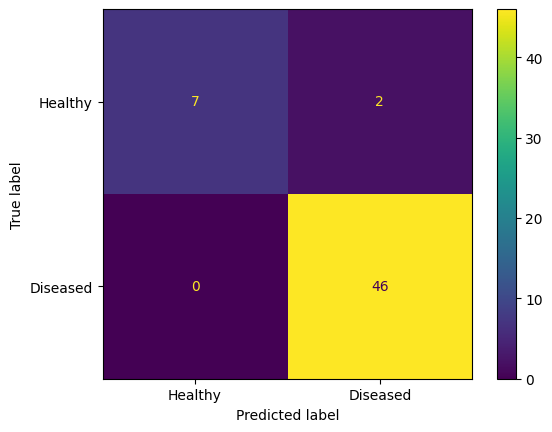

In [68]:
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Healthy", "Diseased"]).plot()

In [69]:
accuracy = accuracy_score(y_test, logistic_prediction)
precision = precision_score(y_test, logistic_prediction)
recall = recall_score(y_test, logistic_prediction)
f1 = f1_score(y_test, logistic_prediction)

print(f"""
Accuracy: {accuracy}
Precision: {precision}
Recall: {recall}
f1: {f1}
""")


Accuracy: 0.9636363636363636
Precision: 0.9583333333333334
Recall: 1.0
f1: 0.9787234042553191



# Decision Tree 

In [70]:
from sklearn import tree

tree_model = tree.DecisionTreeClassifier().fit(x_train, np.ravel(y_train))

tree_prediction = tree_model.predict(x_test)
tree_prediction

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int8)

[Text(0.4444444444444444, 0.9, 'x[4] <= 4.54\ngini = 0.258\nsamples = 125\nvalue = [19, 106]'),
 Text(0.2222222222222222, 0.7, 'x[1] <= 6.303\ngini = 0.019\nsamples = 103\nvalue = [1.0, 102.0]'),
 Text(0.1111111111111111, 0.5, 'gini = 0.0\nsamples = 102\nvalue = [0, 102]'),
 Text(0.3333333333333333, 0.5, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.6666666666666666, 0.7, 'x[8] <= 3.89\ngini = 0.298\nsamples = 22\nvalue = [18, 4]'),
 Text(0.5555555555555556, 0.5, 'gini = 0.0\nsamples = 14\nvalue = [14, 0]'),
 Text(0.7777777777777778, 0.5, 'x[0] <= 2.197\ngini = 0.5\nsamples = 8\nvalue = [4, 4]'),
 Text(0.6666666666666666, 0.3, 'x[3] <= 1.998\ngini = 0.32\nsamples = 5\nvalue = [4, 1]'),
 Text(0.5555555555555556, 0.1, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(0.7777777777777778, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.8888888888888888, 0.3, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]')]

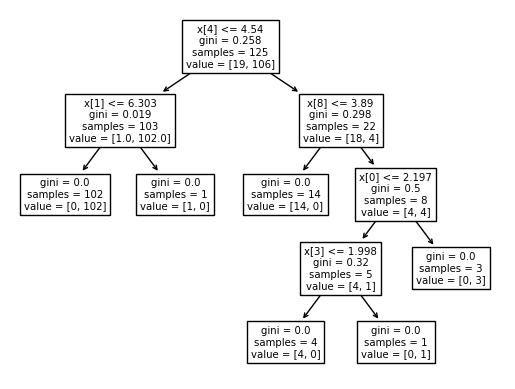

In [71]:
tree.plot_tree(tree_model)

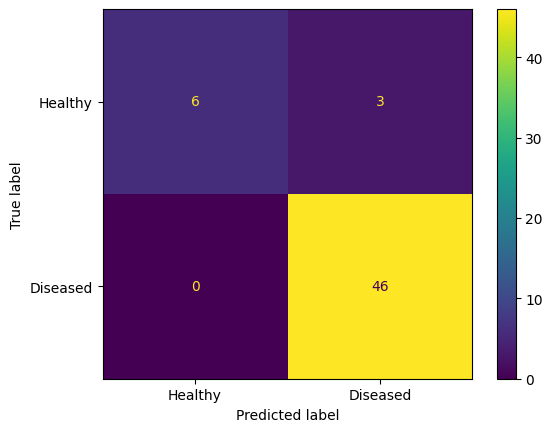

In [72]:
cm = confusion_matrix(y_test, tree_prediction)
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Healthy", "Diseased"]).plot()

In [73]:
accuracy = accuracy_score(y_test, tree_prediction)
precision = precision_score(y_test, tree_prediction)
recall = recall_score(y_test, tree_prediction)
f1 = f1_score(y_test, tree_prediction)

print(f"""
Accuracy: {accuracy}
Precision: {precision}
Recall: {recall}
f1: {f1}
""")


Accuracy: 0.9454545454545454
Precision: 0.9387755102040817
Recall: 1.0
f1: 0.968421052631579



# Gradient boosted Tree

In [75]:
from sklearn.ensemble import HistGradientBoostingClassifier

gb_tree_model = HistGradientBoostingClassifier(max_iter=100).fit(x_train, np.ravel(y_train))

gb_tree_prediction = gb_tree_model.predict(x_test)
gb_tree_prediction

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int8)

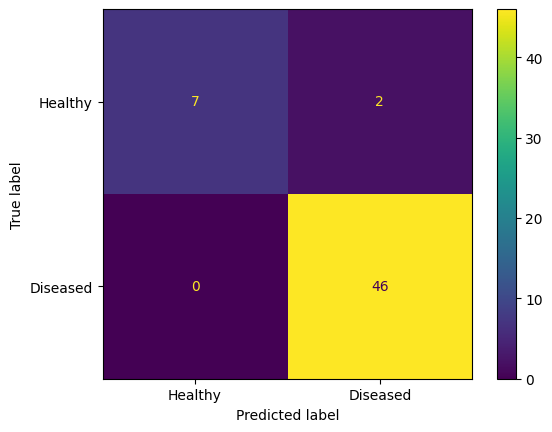

In [76]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, gb_tree_prediction), display_labels = ["Healthy", "Diseased"]).plot()

In [77]:
print(f"""
Accuracy: {accuracy_score(y_test, gb_tree_prediction)}
Precision: {precision_score(y_test, gb_tree_prediction)}
Recall: {recall_score(y_test, gb_tree_prediction)}
f1: {f1_score(y_test, gb_tree_prediction)}
""")


Accuracy: 0.9636363636363636
Precision: 0.9583333333333334
Recall: 1.0
f1: 0.9787234042553191

